## Data Splitting
To stimulate different data owners with the different dataset, we split the dataset by public dataset and private datasets with different sets of labels

In [1]:
# import necessary packages for this notebook 
import numpy as np
import pandas as pd

In [2]:
# define dataset path
dataset_path = '../Datasets/CIFAR10/'
img_path = '../Datasets/CIFAR10/images/'

In [3]:
# get the data of all images
data_df = pd.read_csv(dataset_path + 'data.csv')
data_df

,image,label,label_name
0,00001.png,6,frog
1,00002.png,9,truck
2,00003.png,9,truck
3,00004.png,4,deer
4,00005.png,1,car
...,...,...,...
59995,59996.png,8,ship
59996,59997.png,3,cat
59997,59998.png,5,dog
59998,59999.png,1,car


In [4]:
# get label map
id2label = data_df[['label', 'label_name']].drop_duplicates().sort_values('label').set_index('label').to_dict()['label_name']
id2label[-1] = 'other'
label2id = {v:k for k,v in id2label.items()}
label2id

{'plane': 0,
 'car': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9,
 'other': -1}

In [5]:
def get_dataset(data_df: pd.DataFrame, drop=True, **kwargs):
    """Get a custom dataset by defining label and the associated count value or fraction

    Args:
        data_df (pd.DataFrame): _description_
        drop (bool, optional): whether the data selected will be removed from data_df. Defaults to True.
        kwargs: label'

    Returns:
        _type_: _description_
    """

    label_count_df = pd.DataFrame({
        'label': list(kwargs.keys()),
        'count': list(kwargs.values())
    })

    # sanity check
    for label in label_count_df.label:
        if label == 'other':
            continue
        # assert the label exists
        assert np.logical_or(
            label in data_df.label.astype('str').unique().tolist(),
            label in data_df.label_name.unique().tolist()
        )
        # assert no two labels are the same
        # TODO

    # change the fraction of data to number if the count is a fraction
    for i, (label, count) in label_count_df.iterrows():
        if label == 'other':
            continue
        if count <= 1:
            if isinstance(label, str):
                label = label2id[label]
            label_count_total = len(data_df.query(f'label == {label}'))
            label_count_df.iloc[i, 1] = round(count * label_count_total)

    label_count_df['count'] = label_count_df['count'].astype('int32')
    label_count_df['label'] = label_count_df['label'].apply(
        lambda x: label2id[x])
    # convert a data frame to dictionary
    label_count_dict = dict(
        zip(label_count_df['label'], label_count_df['count']))

    labels = [label for label in label_count_dict if label != -1]

    return_data_idx = [i for label in labels
                       for i in data_df.query(f'label == {label}')
                       .sample(label_count_dict[label]).index
                       ]
    # add indices for other labels
    return_data_idx += [] if -1 not in label_count_dict else \
        data_df.query(f'label not in {labels}') \
        .sample(label_count_dict[-1]).index.tolist()

    images = data_df.image[return_data_idx]
    labels = [int(l)
              for label, count in zip(label_count_df['label'], label_count_df['count'])
              for l in np.ones(count) * label]

    return (
        data_df.iloc[[i for i in data_df.index if i not in return_data_idx]],
        pd.DataFrame({
            'image': images,
            'label': labels
        }).reset_index(drop=True)
    )


# example
data_df, dataset = get_dataset(
    data_df,
    car=0.2,
    bird=0.2,
    cat=1500,
    other=2000
)


In [6]:
# make sure the custom dataset has removed
data_df

,image,label,label_name
0,00001.png,6,frog
1,00002.png,9,truck
2,00003.png,9,truck
3,00004.png,4,deer
4,00005.png,1,car
...,...,...,...
59993,59994.png,5,dog
59994,59995.png,3,cat
59996,59997.png,3,cat
59997,59998.png,5,dog


In [7]:
# display the custom dataset
dataset

,image,label
0,53613.png,1
1,39388.png,1
2,44475.png,1
3,33306.png,1
4,16954.png,1
...,...,...
5895,33783.png,-1
5896,01195.png,-1
5897,14061.png,-1
5898,43864.png,-1


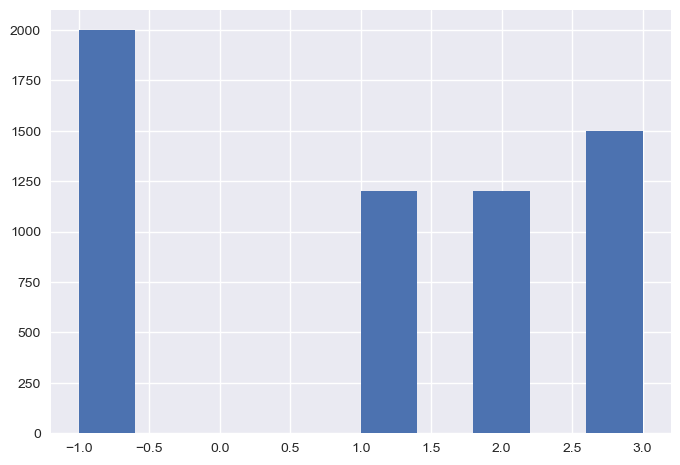

In [8]:
# Display label count distribution
from matplotlib import pyplot as plt
plt.style.use('seaborn')
dataset.label.hist();